
# Calibration

In [28]:
import uuid
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [29]:
def read_eval_results(results):
    with open(results, 'r') as json_file:
        json_list_str = list(json_file)
    json_data = dict()
    json_list = list()
    for json_str in json_list_str:
        result = json.loads(json_str)
        json_data[str(uuid.uuid4())] = result
        json_list.append(result)
   
    return json_list

In [30]:

def get_res(data):
    res = []
    accuracy = 0
    noAnswerCount = 0
    noAnswerIdx = []
    for idx, sample in enumerate(data):
        answer = str(sample["answer"])
        target = str(sample["target"])

        if answer == target:
            accuracy +=1
        if answer == "":
            noAnswerCount += 1
            noAnswerIdx.append(idx + 1)
            continue
#         print(sample.keys())
        
         # Column name to check and replace
        old_column_name = 'calibration_result'
        new_column_name = 'calibration_results'

        if old_column_name in sample.keys():
        
            my_dict = sample["calibration_result"][0]

            if len(sample["calibration_result"]) > 0:
                if str(answer) in sample["calibration_result"][0]:
                    answer_probability = float(my_dict[str(answer)])
                    score = sample["score"]
                    res.append([idx, target, answer, answer_probability, score])
                else: 
                    print(my_dict)
                    print("has no answer")
        else:
            
            my_dict = sample["calibration_results"][0]

            if len(sample["calibration_results"]) > 0:
                if str(answer) in sample["calibration_results"][0]:
                    answer_probability = float(my_dict[str(answer)])
                    score = sample["score"]
                    res.append([idx, target, answer, answer_probability, score])
                else: 
                    print(my_dict)
                    print("has no answer")
            
                
    acc = str(accuracy/len(data))
    print(" Accuracy is : ", str(accuracy/len(data)))
    print(f"{noAnswerCount} sample(s) with index {noAnswerIdx} did not have any answer")
    return res, acc

In [31]:
def cal_dict(res):
    calibration_dict = defaultdict(list)
    for sample in res:
        answer_probability = sample[-2]
        # print(answer_probability)
        if answer_probability <= 0.1:
            calibration_dict['0.00-0.10'].append(sample)
        elif answer_probability <= 0.2:
            calibration_dict['0.11-0.20'].append(sample)
        elif answer_probability <= 0.3:
            calibration_dict['0.21-0.30'].append(sample)
        elif answer_probability <= 0.4:
            calibration_dict['0.31-0.40'].append(sample)
        elif answer_probability <= 0.5:
            calibration_dict['0.41-0.50'].append(sample)
        elif answer_probability <= 0.6:
            calibration_dict['0.51-0.60'].append(sample)
        elif answer_probability <= 0.7:
            calibration_dict['0.61-0.70'].append(sample)
        elif answer_probability <= 0.8:
            calibration_dict['0.71-0.80'].append(sample)
        elif answer_probability <= 0.9:
            calibration_dict['0.81-0.90'].append(sample)
        elif answer_probability <= 1.0:
            calibration_dict['0.91-1.00'].append(sample)
    return calibration_dict

In [32]:
def buckets(calibration_dict):    
    bucket_accuracy = defaultdict(int)
    bucket_average = defaultdict(int)

    for bucket in calibration_dict:
        current_bucket_samples = calibration_dict[bucket]
        current_bucket_average = [sample[-2] for sample in current_bucket_samples]
        current_bucket_average = np.mean(current_bucket_average)
        current_bucket_correct = [sample[-1] for sample in current_bucket_samples]
        current_bucket_accuracy = np.mean(current_bucket_correct)
        bucket_accuracy[bucket] = current_bucket_accuracy
        bucket_average[bucket] = current_bucket_average

    print("Bucket Average: ", bucket_average )
    print()
    print("Bucket Accuarcy: ",bucket_accuracy)
    
    return bucket_average, bucket_accuracy


In [33]:
def fill_missing_buckets(bucket_mapping, value = np.nan):
    names = ['0.00-0.10', '0.11-0.20', '0.21-0.30', '0.31-0.40', '0.41-0.50', '0.51-0.60', '0.61-0.70', '0.71-0.80', '0.81-0.90', '0.91-1.00']
    for name in names:
        if name not in bucket_mapping:
            print(f"Missing bucket {name}")
            bucket_mapping[name] = value
    print()
    return bucket_mapping


In [34]:
def bucket_sample(calibration_dict):
    bucket_sample_count = defaultdict(int)

    for bucket in calibration_dict:
        bucket_sample_count[bucket] = len(calibration_dict[bucket])
    return bucket_sample_count

In [35]:
def make_barGraph(bucket_sample_count, outpath):
    names = ['0.00-0.10', '0.11-0.20', '0.21-0.30', '0.31-0.40', '0.41-0.50', '0.51-0.60', '0.61-0.70', '0.71-0.80', '0.81-0.90', '0.91-1.00']
    values = [bucket_sample_count[bucket] for bucket in names]
    color=['red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'teal', 'navy']
    plt.bar(names, values, color=color)
    # plt.title("Sample Count")
    plt.xlabel("Confidence Interval")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.savefig(outpath)
    plt.show()
    
    return names


In [37]:
import matplotlib.pyplot as plt
import numpy as np

def make_reliability(names, bucket_average, bucket_accuracy, outpath, x_label_size=16, y_label_size=16, legend_font_size=16):
    buckets = names    
    avg = [bucket_average[bucket] for bucket in buckets]
    acc = [bucket_accuracy[bucket] for bucket in buckets]

    xy = np.arange(0, 1.1, 0.1)

    # Create the reliability plot as a line graph
    plt.figure(figsize=(10, 6))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.plot(xy, xy, linestyle='--', label='Perfect Reliability', color='blue')
    plt.plot(avg, acc, marker='s', markersize=8, linestyle='-', label='Reliability Plot', color='green')

    # Create bars at each point in the reliability plot with a slightly darker green color
    plt.bar(avg, acc, width=0.1, align='center', color='lightgreen', alpha=0.7)

    # Set x-axis and y-axis limits to start from 0
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # Set x-axis labels from 0.0 to 1.0 with steps of 0.1
    x_ticks = [str(round(x, 1)) for x in xy]
    plt.xticks(xy, x_ticks, fontsize=x_label_size, ha='right')

    plt.title("Reliability Plot", fontsize=24)
    plt.xlabel("Confidence", fontsize=24)
    
    # Set the y-axis label and font size
    plt.ylabel("Accuracy", fontsize=24)

    # Set the font size for y-axis tick labels
    plt.yticks(fontsize=y_label_size)

    # Set the legend font size to the specified value
    plt.legend(fontsize=18)
    plt.grid(True)

    # Specify the folder path and file name for saving the image
    save_path = outpath

    # Save the image
    plt.savefig(save_path)
    plt.show()

# Example usage:
# make_reliability(names, bucket_average, bucket_accuracy, outpath, x_label_size=14, y_label_size=16, legend_font_size=14)


In [38]:
def calc_ece(names, bucket_accuracy, bucket_average):
    import math
    n = len(res)
    ece = 0
    for x in names:
        acc = bucket_accuracy[x]
        conf = bucket_average[x]
        if math.isnan(acc) or math.isnan(conf) or acc == 0.0 or conf == 0.0:
            continue
        bm = bucket_sample_count[x]
        ece += ((bm / n) * abs(acc - conf))
    print("ECE is: ", ece)
    return ece
    

In [39]:
def extract_name(path):
    import os
    filename = os.path.basename(path)
    text = filename.split('.jsonl')[0]
    return text


vllm_llama2_13b_1.0_repeat_copy_code_result
 Accuracy is :  0.5
0 sample(s) with index [] did not have any answer
Bucket Average:  defaultdict(<class 'int'>, {'0.51-0.60': 0.6, '0.71-0.80': 0.8, '0.41-0.50': 0.5, '0.21-0.30': 0.3, '0.11-0.20': 0.2, '0.81-0.90': 0.9, '0.61-0.70': 0.7, '0.31-0.40': 0.39999999999999997, '0.00-0.10': 0.1})

Bucket Accuarcy:  defaultdict(<class 'int'>, {'0.51-0.60': 1.0, '0.71-0.80': 1.0, '0.41-0.50': 0.6666666666666666, '0.21-0.30': 0.3333333333333333, '0.11-0.20': 0.3, '0.81-0.90': 1.0, '0.61-0.70': 1.0, '0.31-0.40': 0.5, '0.00-0.10': 0.5})
Missing bucket 0.91-1.00

Missing bucket 0.91-1.00

Missing bucket 0.91-1.00



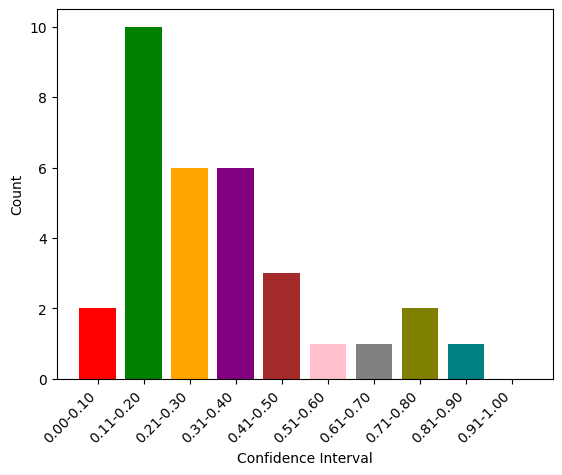

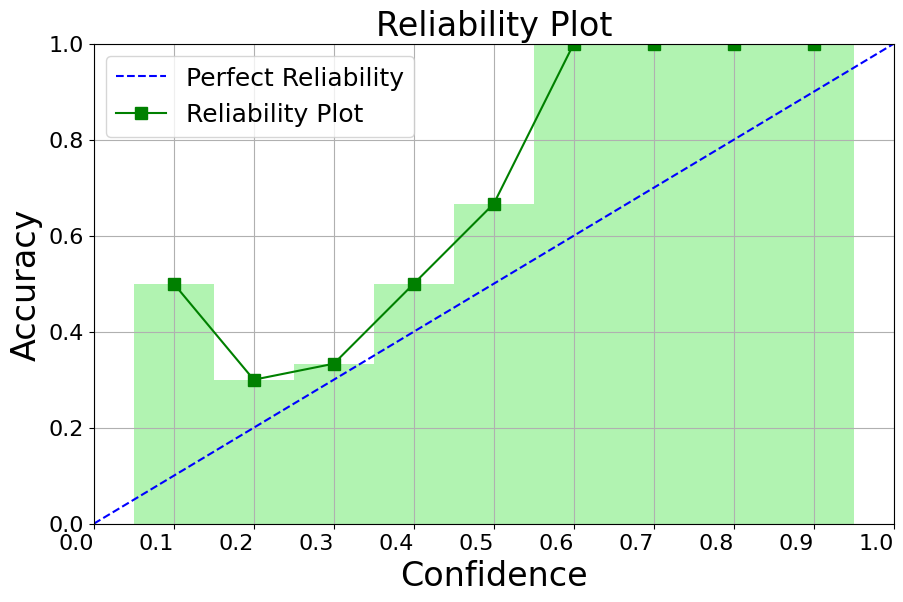

ECE is:  0.13437499999999997
Result for : vllm_llama2_13b_1.0_repeat_copy_code_result

----------------------
vllm_llama2_13b_1.0_object_counting_code_result
 Accuracy is :  0.812
0 sample(s) with index [] did not have any answer
Bucket Average:  defaultdict(<class 'int'>, {'0.21-0.30': 0.3, '0.81-0.90': 0.9, '0.71-0.80': 0.7999999999999998, '0.51-0.60': 0.6, '0.91-1.00': 1.0, '0.61-0.70': 0.6999999999999998, '0.31-0.40': 0.4, '0.41-0.50': 0.5, '0.11-0.20': 0.2})

Bucket Accuarcy:  defaultdict(<class 'int'>, {'0.21-0.30': 0.25, '0.81-0.90': 0.92, '0.71-0.80': 0.864406779661017, '0.51-0.60': 0.8421052631578947, '0.91-1.00': 0.9661016949152542, '0.61-0.70': 0.8888888888888888, '0.31-0.40': 0.1111111111111111, '0.41-0.50': 0.3333333333333333, '0.11-0.20': 0.0})
Missing bucket 0.00-0.10

Missing bucket 0.00-0.10

Missing bucket 0.00-0.10



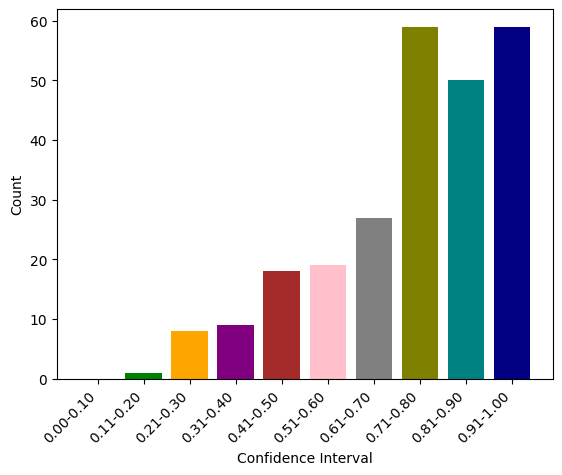

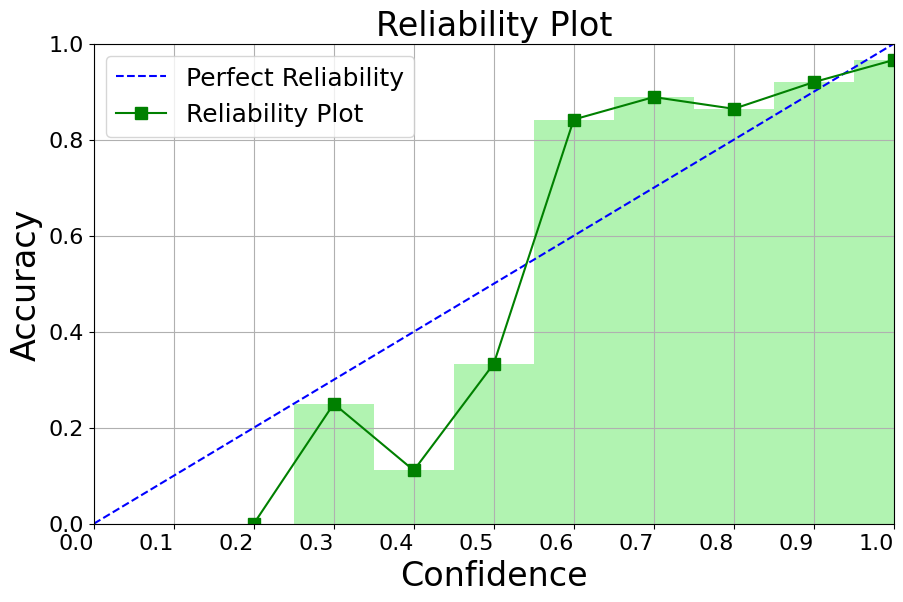

ECE is:  0.09000000000000007
Result for : vllm_llama2_13b_1.0_object_counting_code_result

----------------------


In [54]:
import glob
import json

# Define the folder path
folder_path = '/Users/anubhakabra/Desktop/SEM3/QA/extra_experiments/RESULT_JSONLS_CODE_1.0'
#This folder stores the bar graph with all the buckets
out_bar_folder = '/Users/anubhakabra/Desktop/SEM3/QA/extra_experiments/RESULT_JSONLS_CODE_1.0/BAR/'
#This folder stores all the reliability plots
out_line_folder= '/Users/anubhakabra/Desktop/SEM3/QA/extra_experiments/RESULT_JSONLS_CODE_1.0/LINE/'
#This folder stores the results of ECE and ACC in a text file
out_text_folder = '/Users/anubhakabra/Desktop/SEM3/QA/extra_experiments/RESULT_JSONLS_CODE_1.0/TEXT/'

# Define a list to store the data from JSONL files
data = []

# Use glob to find all JSONL files in the folder
jsonl_files = glob.glob(f"{folder_path}/*.jsonl")


# Loop through each JSONL file and read its contents
for jsonl_file in jsonl_files:
    out_name = extract_name(jsonl_file)
    print(out_name)
    out_bar = out_bar_folder + out_name + ".png"
    out_line = out_line_folder + out_name + ".png"
    out_text = out_text_folder + out_name + ".txt"
    
    try:
        data = read_eval_results(jsonl_file)
        data = data[0]
        res, accuracy = get_res(data)
        calibration_dict = cal_dict(res)
        bucket_average, bucket_accuracy = buckets(calibration_dict)
        bucket_average = fill_missing_buckets(bucket_average)
        bucket_accuracy = fill_missing_buckets(bucket_accuracy)
        calibration_dict = fill_missing_buckets(calibration_dict, [])
        bucket_sample_count = bucket_sample(calibration_dict)
        names = make_barGraph(bucket_sample_count, out_bar)
        make_reliability(names, bucket_average, bucket_accuracy, out_line)
        ece = calc_ece(names, bucket_accuracy, bucket_average)
        
        print("Result for : " + str(out_name) + '\n')
        print("----------------------")
        
        # Open a file for writing (creates a new file or overwrites an existing file)
        with open(out_text, "w") as file:
            file.write("Result for : " + str(out_name) + '\n')
            file.write("Length is: " + str(len(data)) + '\n')
            file.write("Accuracy is: " + str(accuracy))
            file.write('\n')
            file.write("ECE is: " + str(ece))

        
        
       
    except json.JSONDecodeError:
        print(f"Error parsing JSON in file: {jsonl_file}")


